<a href="https://colab.research.google.com/github/artoowang/ray_tracer_colab/blob/main/Ray_Tracer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Initialization

In [1]:
import imageio
import numpy as np
import matplotlib.pyplot as plt
import os
from PIL import Image

In [2]:
# Initializations that require downloading.
imageio.plugins.freeimage.download()
%pip install git+https://github.com/artoowang/cython_colab.git
import cython_colab

Imageio: 'libfreeimage-3.16.0-linux64.so' was not found on your computer; downloading it now.
Try 1. Download from https://github.com/imageio/imageio-binaries/raw/master/freeimage/libfreeimage-3.16.0-linux64.so (4.6 MB)
Downloading: 8192/4830080 bytes (0.2%)1769472/4830080 bytes (36.6%)4694016/4830080 bytes (97.2%)4830080/4830080 bytes (100.0%)
  Done
File saved as /root/.imageio/freeimage/libfreeimage-3.16.0-linux64.so.
  Cloning https://github.com/artoowang/cython_colab.git to /tmp/pip-req-build-r1rqxvi5
  Running command git clone -q https://github.com/artoowang/cython_colab.git /tmp/pip-req-build-r1rqxvi5
  Created wheel for cython-colab: filename=cython_colab-0.1-py3-none-any.whl size=15329 sha256=37d25ebb8e5cf78ab7cf9582f21d016261988efcb01b2c4e1f31c761c7878715
  Stored in directory: /tmp/pip-ephem-wheel-cache-s7the71d/wheels/b8/34/21/093444b60cd46f3574266da48cf6757ff776a72fddc548f846
Successfully b

In [3]:
if os.path.exists('ray_tracer_colab'):
  print('Use local ray_tracer_colab repo.')
else:
  print('Checking out ray_tracer_colab repo ...')
  !git clone https://github.com/artoowang/ray_tracer_colab.git

Checking out ray_tracer_colab repo ...
Cloning into 'ray_tracer_colab'...
remote: Enumerating objects: 62, done.
remote: Counting objects: 100% (62/62), done.
remote: Compressing objects: 100% (38/38), done.
remote: Total 62 (delta 26), reused 50 (delta 19), pack-reused 0
Unpacking objects: 100% (62/62), done.


## Run

### ray_tracer_wrapper_setup.py

In [6]:
%%file ray_tracer_wrapper_setup.py

from distutils.core import setup  
from distutils.extension import Extension  
from Cython.Build import cythonize
import sys

# It is important to make sure the extension name, .pyx file, and this setup
# file names are all consistent with each other. E.g., to build a module called
# 'example_mod', the extension name should be 'example_mod', .pyx file should be
# example_mod.pyx, and the setup file should be example_mod_setup.py. These are
# used in various places in the module reload utility methods.
module_name = 'ray_tracer_wrapper'

if sys.platform == 'darwin':
  sys_dep_compile_args = [
      '-Wno-unreachable-code',
      '-Wp,-fopenmp',
  ]
  sys_dep_link_args = [
      '-Wp,-fopenmp',
      '-lomp',
  ]
else:
  sys_dep_compile_args = ['-fopenmp']
  sys_dep_link_args = ['-fopenmp']

extensions = [
  Extension(module_name,
            [f'{module_name}.pyx', 'ray_tracer_main.cc',
             'ray_tracer_colab/src/scene.cc'],
            language='c++',
            extra_compile_args=[
                '-std=c++17',
                '-Iray_tracer_colab/include',
            ] + sys_dep_compile_args,
            extra_link_args=sys_dep_link_args,
           ),
]

setup(ext_modules = cythonize(extensions, language_level='3'))

Writing ray_tracer_wrapper_setup.py


### ray_tracer_main.h

In [7]:
%%file ray_tracer_main.h

#ifndef RAY_TRACER_MAIN_H
#define RAY_TRACER_MAIN_H

#include "camera.h"
#include "hittable_list.h"
#include "scene.h"

Scene CreateScene(int image_width, int image_height);

#endif  // RAY_TRACER_MAIN_H

Writing ray_tracer_main.h


### ray_tracer_main.cc

In [8]:
%%file ray_tracer_main.cc

#include "ray_tracer_main.h"

#include <fstream>
#include <iostream>
#include <utility>

#include "rtweekend.h"
#include "color.h"
#include "material.h"
#include "sphere.h"

hittable_list CreateRandomWorld() {
    hittable_list world;

    auto ground_material = make_shared<lambertian>(color(0.5, 0.5, 0.5));
    world.add(make_shared<sphere>(point3(0,-1000,0), 1000, ground_material));

    for (int a = -11; a < 11; a++) {
        for (int b = -11; b < 11; b++) {
            auto choose_mat = random_double();
            point3 center(a + 0.9*random_double(), 0.2, b + 0.9*random_double());

            if ((center - point3(4, 0.2, 0)).length() > 0.9) {
                shared_ptr<material> sphere_material;

                if (choose_mat < 0.8) {
                    // diffuse
                    auto albedo = color::random() * color::random();
                    sphere_material = make_shared<lambertian>(albedo);
                    world.add(make_shared<sphere>(center, 0.2, sphere_material));
                } else if (choose_mat < 0.95) {
                    // metal
                    auto albedo = color::random(0.5, 1);
                    auto fuzz = random_double(0, 0.5);
                    sphere_material = make_shared<metal>(albedo, fuzz);
                    world.add(make_shared<sphere>(center, 0.2, sphere_material));
                } else {
                    // glass
                    sphere_material = make_shared<dielectric>(1.5);
                    world.add(make_shared<sphere>(center, 0.2, sphere_material));
                }
            }
        }
    }

    auto material1 = make_shared<dielectric>(1.5);
    world.add(make_shared<sphere>(point3(0, 1, 0), 1.0, material1));

    auto material2 = make_shared<lambertian>(color(0.4, 0.2, 0.1));
    world.add(make_shared<sphere>(point3(-4, 1, 0), 1.0, material2));

    auto material3 = make_shared<metal>(color(0.7, 0.6, 0.5), 0.0);
    world.add(make_shared<sphere>(point3(4, 1, 0), 1.0, material3));

    return world;
}

Scene CreateScene(int image_width, int image_height) {
  point3 lookfrom(13,2,3);
  point3 lookat(0,0,0);
  vec3 vup(0,1,0);
  auto dist_to_focus = 10.0;
  auto aperture = 0.1;
  const double aspect_ratio = static_cast<double>(image_width) / image_height;
  Camera camera(lookfrom, lookat, vup, 20, aspect_ratio, aperture, dist_to_focus);
  return Scene(image_width, image_height,
               /*samples_per_pixel=*/10,
               /*max_depth=*/50, CreateRandomWorld(), std::move(camera));
}

Writing ray_tracer_main.cc


### ray_tracer_wrapper.pyx

In [12]:
%%file ray_tracer_wrapper.pyx

from IPython import display
import numpy as np
from cython.parallel import prange, threadid
import time
from tqdm.notebook import tqdm
from PIL import Image

from libc.stdint cimport uint8_t
from libcpp cimport bool

from ray_tracer_colab.utils.preview_display import PreviewDisplay


cdef extern from 'ray_tracer_main.h':
  cdef cppclass Scene:
    bool RenderLine(int y, uint8_t* line) nogil
  Scene CreateScene(int image_width, int image_height)


def run_parallel(Py_ssize_t image_width, Py_ssize_t image_height):
  # Create the bytearray to hold the ray tracer output.
  cdef bytearray buffer = bytearray(image_width * image_height * 3)
  # We need to explicitly declare a uint8_t pointer because we cannot access
  # bytearray within prange().
  cdef uint8_t* ptr = buffer
  cdef uint8_t* line

  cdef Py_ssize_t y
  cdef Scene scene = CreateScene(image_width, image_height)

  progress_bar = tqdm(total=image_height)
  preview = PreviewDisplay(every_n_sec=10.0, image_width=image_width,
                           image_height=image_height)

  # 'dynamic' schedule allows each thread to pick one line at a time, and thus
  # makes sure all threads will be busy for the entire image.
  for y in prange(image_height, nogil=True, schedule='dynamic'):
    with gil:
      progress_bar.update(1)
      preview.maybe_update(buffer)
    # The row 0 in a PIL Image buffer is at the top, while in our image space
    # y = 0 is the bottom row, so we flip it here to find the pointer to the
    # correct output line.
    line = ptr + (image_height - y - 1) * image_width * 3
    scene.RenderLine(y, line)

  # Final update to progress bar and preview image.
  progress_bar.close()
  preview.update(buffer)
  return preview.get_image()

Overwriting ray_tracer_wrapper.pyx


### Build module

In [13]:
ray_tracer_wrapper = cython_colab.build_extension('ray_tracer_wrapper')

Build extension ray_tracer_wrapper ...
Next reload number: 2
Compiling ray_tracer_wrapper.pyx because it changed.
[1/1] Cythonizing ray_tracer_wrapper.pyx
running build_ext
building 'ray_tracer_wrapper' extension
x86_64-linux-gnu-gcc -pthread -Wno-unused-result -Wsign-compare -DNDEBUG -g -fwrapv -O2 -Wall -g -fdebug-prefix-map=/build/python3.7-Y7dWVB/python3.7-3.7.12=. -fstack-protector-strong -Wformat -Werror=format-security -g -fdebug-prefix-map=/build/python3.7-Y7dWVB/python3.7-3.7.12=. -fstack-protector-strong -Wformat -Werror=format-security -Wdate-time -D_FORTIFY_SOURCE=2 -fPIC -I/usr/include/python3.7m -c ray_tracer_wrapper.cpp -o build/temp.linux-x86_64-3.7/ray_tracer_wrapper.o -std=c++17 -Iray_tracer_colab/include -fopenmp
x86_64-linux-gnu-gcc -pthread -Wno-unused-result -Wsign-compare -DNDEBUG -g -fwrapv -O2 -Wall -g -fdebug-prefix-map=/build/python3.7-Y7dWVB/python3.7-3.7.12=. -fstack-protector-strong -Wformat -Werror=format-security -g -fdebug-prefix-map=/build/python3.7-Y7

### Test

  0%|          | 0/180 [00:00<?, ?it/s]

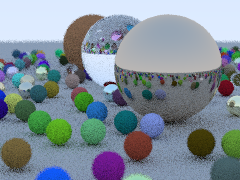

In [14]:
#img = ray_tracer_wrapper.run(240, 180)
#img = ray_tracer_wrapper.run(1200, 645)
#img = ray_tracer_wrapper.run_parallel(64, 32)
img = ray_tracer_wrapper.run_parallel(240, 180)
#img = ray_tracer_wrapper.run_parallel(1200, 645)
#Image.fromarray((img * 255).astype(np.uint8))

## Reload local modules

This is needed to reload the modified Python modules from the local directory.

In [38]:
from importlib import reload
import utils.preview_display
reload(utils.preview_display)

<module 'utils.preview_display' from '/Users/cpwang/Programs/ray-tracer-colab/utils/preview_display.py'>